In [1]:
from segment.modules.semibase import Base
from segment.modules.semseg.deeplabv3plus import DualDeepLabV3Plus
import torch
from torchvision import transforms as T
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
import numpy as np
import math
from segment.util import  color_map
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import cleanlab
from sklearn.manifold import TSNE

D:\Dev_soft\Anaconda3\envs\MyPYL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Dev_soft\Anaconda3\envs\MyPYL\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
D:\Dev_soft\Anaconda3\envs\MyPYL\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


In [2]:
num_classes = 2
ckpt_path = '../temp/panaro.ckpt'

cmap = color_map('eye')

model = DualDeepLabV3Plus('resnet50',num_classes)

sd = torch.load(ckpt_path, map_location='cpu')['state_dict']
if 'state_dict' in sd:
    # If 'state_dict' exists, use it directly
    sd = sd['state_dict']
new_state_dict = {}
for key, value in sd.items():
    # if not key.startswith('module.'):  # 如果关键字没有"module."前缀，加上该前缀
    #     if 'module.' + key in model.state_dict():
    #         # 模型在多GPU上训练并保存，加载权重时加上"module."前缀
    #         key = 'module.' + key
    key = key.replace('model.', '')
    new_state_dict[key] = value

In [3]:
model.load_state_dict(new_state_dict)
model.eval()
image_path = './V0400.jpg'
mask_path = './V0400_noisy.bmp'
transforms = T.Compose([T.Resize((512,512)),T.ToTensor()])
unlabeled_volume_batch = transforms(Image.open(image_path)).unsqueeze(dim=0)
mask_tensor = transforms((Image.open(mask_path))).squeeze()

T = 4
_, _, w, h = unlabeled_volume_batch.shape
volume_batch_r = unlabeled_volume_batch.repeat(2, 1, 1, 1)
stride = volume_batch_r.shape[0] // 2
preds = torch.zeros([stride * T, num_classes, w, h]).cuda()
for i in range(T // 2):
    ema_inputs = volume_batch_r + torch.clamp(torch.randn_like(volume_batch_r) * 0.1, -0.2, 0.2)
    with torch.no_grad():
        preds[2 * stride * i:2 * stride * (i + 1)] = model(ema_inputs)['out1']
preds = F.softmax(preds, dim=1)
preds = preds.reshape(T, stride, num_classes, w, h)
preds = torch.mean(preds, dim=0)
uncertainty = -1.0 * torch.sum(preds * torch.log(preds + 1e-6), dim=1, keepdim=True)
uncertainty = uncertainty / math.log(2)  # normalize uncertainty, cuz ln2 is the max value


# 将uncertainty转换为numpy数组
uncertainty_np = uncertainty.squeeze().cpu().numpy()
mask = mask_tensor.cpu().numpy()
out_od = model(unlabeled_volume_batch)['out1']
preds = torch.argmax(out_od,dim=1)
preds_np = preds.squeeze().cpu().numpy()

In [4]:
print(mask.shape)
print(uncertainty_np.shape)
print(preds_np.shape)

(512, 512)
(512, 512)
(512, 512)


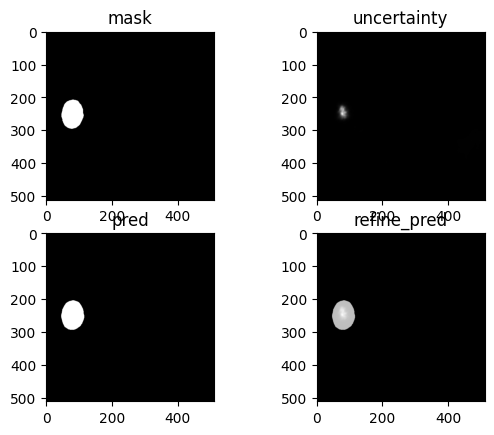

In [5]:
mask[mask > 0] = 1
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(mask,cmap='gray')
axes[0,0].set_title('mask')
axes[0,1].imshow(uncertainty_np,cmap='gray')
axes[0,1].set_title('uncertainty')
axes[1,0].imshow(preds_np,cmap='gray')
axes[1,0].set_title('pred')
axes[1,1].imshow(preds_np+uncertainty_np,cmap='gray')
axes[1,1].set_title('refine_pred')
plt.show()

In [6]:
pred_soft_np = torch.softmax(out_od, dim=1).cpu().detach().numpy()
masks_np = mask
preds_softmax_np_accumulated = np.swapaxes(pred_soft_np, 1, 2)
preds_softmax_np_accumulated = np.swapaxes(preds_softmax_np_accumulated, 2, 3)
preds_softmax_np_accumulated = preds_softmax_np_accumulated.reshape(-1, num_classes)
preds_softmax_np_accumulated = np.ascontiguousarray(preds_softmax_np_accumulated)
masks_np_accumulated = masks_np.reshape(-1).astype(np.uint8)
noise = cleanlab.pruning.get_noise_indices(masks_np_accumulated, preds_softmax_np_accumulated,
                                           prune_method='prune_by_noise_rate', n_jobs=1)

In [7]:
print(preds_softmax_np_accumulated.shape)
print(masks_np_accumulated.shape)

(262144, 2)
(262144,)


In [8]:
print(np.unique(noise))
print(noise.shape)
confident_maps_np = np.squeeze(noise.reshape(-1, 512,512).astype(np.uint8))
print("confident_masp_np:{}".format(confident_maps_np.shape))
print("masks_np:{}".format(masks_np.shape))

smooth_arg = 0.8
fixed_corrected_masks_np = masks_np + confident_maps_np * np.power(-1, masks_np) * smooth_arg
hard_corrected_masks_np = masks_np + confident_maps_np * np.power(-1, masks_np)

uncertainty_np_squeeze = np.squeeze(uncertainty_np)
uncertainty_smooth_arg = 1 - uncertainty_np_squeeze
uncertainty_corrected_masks_np = masks_np + confident_maps_np * np.power(-1, masks_np) * uncertainty_smooth_arg

[False]
(262144,)
confident_masp_np:(512, 512)
masks_np:(512, 512)


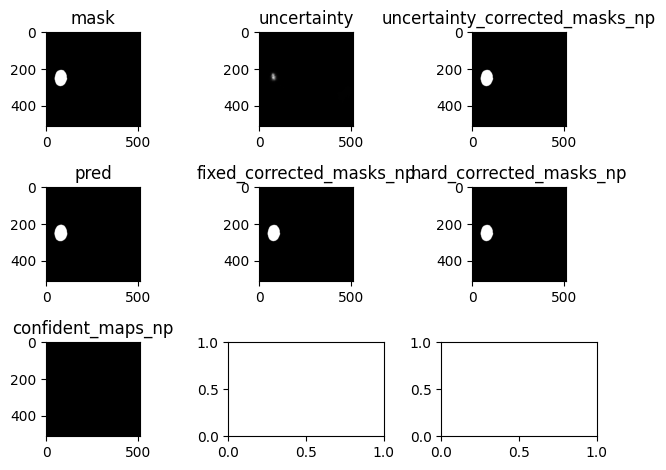

In [9]:
fig, axes = plt.subplots(3, 3)
axes[0,0].imshow(mask,cmap='gray')
axes[0,0].set_title('mask')
axes[0,1].imshow(uncertainty_np,cmap='gray')
axes[0,1].set_title('uncertainty')
axes[1,0].imshow(preds_np,cmap='gray')
axes[1,0].set_title('pred')
axes[1,1].imshow(fixed_corrected_masks_np,cmap='gray')
axes[1,1].set_title('fixed_corrected_masks_np')
axes[0,2].imshow(uncertainty_corrected_masks_np,cmap='gray')
axes[0,2].set_title('uncertainty_corrected_masks_np')
axes[1,2].imshow(hard_corrected_masks_np,cmap='gray')
axes[1,2].set_title('hard_corrected_masks_np')
axes[2,0].imshow(confident_maps_np,cmap='gray')
axes[2,0].set_title('confident_maps_np')
plt.tight_layout()
plt.show()

In [10]:
hard_minus_mask = hard_corrected_masks_np-mask
fixed_minus_mask = fixed_corrected_masks_np-mask
print(np.unique(hard_minus_mask))
print(np.unique(fixed_minus_mask))

[0.]
[0.]
